### Use trained models to classify collection of tweets

In [50]:
import pandas as pd
from itertools import combinations
from torchtext import vocab
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
from torchtext.legacy.data import Field, LabelField, TabularDataset, BucketIterator, Iterator
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
df_test = pd.read_csv("data/Twitter/clean_twitter_info_annotated.csv")
df_test = df_test[df_test['clean_tweet'].notna()]
# assign dummy label to work more easily with prediction code
df_test['label'] = 0

In [20]:
df_train = pd.read_csv("data/Twitter/hate_twitter/hate_upsampled_train.csv")
df_val = pd.read_csv("data/Twitter/hate_twitter/hate_upsampled_val.csv")

df_train = df_train[df_train['clean_tweet'].notna()]
df_val = df_val[df_val['clean_tweet'].notna()]

df_train[["clean_tweet", "label"]].to_csv("data/Twitter/hate_twitter/train.csv")
df_val[["clean_tweet", "label"]].to_csv("data/Twitter/hate_twitter/val.csv")
df_test[["clean_tweet", "label"]].to_csv("data/Twitter/hate_twitter/test.csv")

In [39]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
device = 'cpu'

if device == 'cpu':
    VECTORS_CACHE_DIR = '.vector_cache/'
    # Please change above to your cache
else:
    VECTORS_CACHE_DIR = '.vector_cache/'
   
BATCH_SIZE = 64


In [40]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, text, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        self.embedding_dim = embedding_dim
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data = text.vectors
        self.dropout = nn.Dropout(dropout)

        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                          #  dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        # #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]

        #packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths,batch_first=True, 
                                                            enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_lengths - 1, :self.embedding_dim]
        out_reverse = output[:, 0, self.embedding_dim:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        dense_outputs = self.dropout(out_reduced)
        dense_outputs=self.fc(dense_outputs)

        dense_outputs = torch.squeeze(dense_outputs, 1)
        outputs = torch.sigmoid(dense_outputs)
        return outputs.to(device)

In [41]:
TEXT = Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = LabelField(sequential=False, use_vocab=False, dtype = torch.float,batch_first=True)
fields = [(None, None), ('clean_tweet',TEXT),('label', LABEL)]
train, val, test = TabularDataset.splits(path = "data/Twitter/hate_twitter/", 
                                        train='train.csv',validation='val.csv',
                                         test='test.csv', format='csv',
                                         fields= fields, skip_header=True)
TEXT.build_vocab(train,min_freq=3,vectors = "glove.twitter.27B.100d")
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, val, test), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.clean_tweet),
    sort_within_batch=True,
    device = device)
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 50
num_output_nodes = 1
num_layers = 2
dropout = 0.2

/home/npodpx/venv/lib/python3.9/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [42]:
def load_checkpoint(load_path, model, optimizer, device):
    '''
    Used in evaluate() to load the current best model.
    
    Inputs:
        - load_path: string, where to save model specs.
        - model: a PyTorch model object.
        - optimizer: a PyTorch Optimizer to be used.
        - device: string, 'cpu' or 'cuda' if using google colab.
        
    Returns: float, the models last validation loss.
    
    Other Effects:
        - Loads the saved state at load_path
        into the current model object
    '''
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return model


In [43]:
def classify_unlabeled(model, test_loader, device):
    '''
    Accepts the current best model and evaluates
    the test dataset. Printing test accuracy and
    an sklearn confusion matrix report.
    
    Inputs:
    - model: PyTorch model object, the current best model.
    - test_loader: an iterator with test data.
    - device: string, 'cpu' or 'cuda' if using google colab.
    
    Returns: None.
    
    Other Effects:
        Prints test accuracy.
        Prints an Accuracy / F1 Report (sklearn)
        Prints a Confusion Matrix (sklearn & matplotlib)
    '''
    y_pred = []

    model.eval()
    with torch.no_grad():
        for ((text, text_len),_) in test_loader:  
 
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)   
            output = torch.round(output)

            y_pred.extend(output.tolist())

    return y_pred

In [44]:
# Evaluate
best_model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, TEXT.vocab, num_layers, 
                   bidirectional = True, dropout = dropout)

optimizer = optim.Adam(best_model.parameters(), lr=0.00001)

best_model = load_checkpoint('model.pt', best_model, optimizer, device)

y_pred = classify_unlabeled(best_model, test_iterator, device)

Model loaded from <== model.pt


In [46]:
# confirm y pred and df test have same size
len(y_pred)

15553

In [47]:
# confirm y pred and df test have same size
df_test.shape

(15553, 16)

In [60]:
df_test['label_pred'] = y_pred
df_test['date_dt'] = pd.to_datetime(df_test['Datetime'])
df_test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'label'], inplace=True)

In [69]:
df_test['date_day'] = df_test['date_dt'].dt.date

In [65]:
# show number of hate tweets in labeled data
df_test.groupby(['tag'])['tweet_id'].count()

tag
none      12828
racism       15
sexism     2710
Name: tweet_id, dtype: int64

In [66]:
df_test.groupby(['tag', 'label_pred'])['tweet_id'].count()

tag     label_pred
none    0.0           12417
        1.0             411
racism  0.0              15
sexism  0.0            2497
        1.0             213
Name: tweet_id, dtype: int64

In [103]:
df_test[(df_test['label_pred'] == 0) & (df_test['tag'] == 'sexism')].head(70)

,tweet_id,tag,Datetime,Tweet Id,Text,Username,Place,Coordinates,UserLocation,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK,label_pred,date_dt,date_day
15,572346080911736832,sexism,2015-03-02 10:41:54+00:00,5.723461e+17,These two are revolting #MKR #MKR2015,hermosavogue_,NaN,NaN,"London, England","['mkr', 'mkr2015']",two revolting mkr mkr2015,these two are revolting <hashtag> mkr <allcaps...,These two revolting MKR MKR2015,0.0,2015-03-02 10:41:54+00:00,2015-03-02
16,572346080911736832,sexism,2015-03-02 10:41:54+00:00,5.723461e+17,These two are revolting #MKR #MKR2015,hermosavogue_,NaN,NaN,"London, England","['mkr', 'mkr2015']",two revolting mkr mkr2015,these two are revolting <hashtag> mkr <allcaps...,These two revolting MKR MKR2015,0.0,2015-03-02 10:41:54+00:00,2015-03-02
17,572319306387599360,sexism,2015-03-02 08:55:30+00:00,5.723193e+17,The menus look like they were made by a 5 year...,colonelkickhead,NaN,NaN,Sydney,['mkr'],menus look like made year old little girlin ca...,the menus look like they were made by a <numbe...,The menus look like made year old little girl ...,0.0,2015-03-02 08:55:30+00:00,2015-03-02
19,572347584339046402,sexism,2015-03-02 10:47:52+00:00,5.723476e+17,Were butchers but can't tell red poultry is no...,Sir_Smartee,"Place(fullName='Darwin, Northern Territory', n...","Coordinates(longitude=130.84419658, latitude=-...",Darwin,"['salmonellaqueens', 'mkr']",butchers cant tell red poultry cooked salmonel...,were butchers but can't tell red poultry is no...,Were butchers can't tell red poultry cooked sa...,0.0,2015-03-02 10:47:52+00:00,2015-03-02
20,572347584339046402,sexism,2015-03-02 10:47:52+00:00,5.723476e+17,Were butchers but can't tell red poultry is no...,Sir_Smartee,"Place(fullName='Darwin, Northern Territory', n...","Coordinates(longitude=130.84419658, latitude=-...",Darwin,"['salmonellaqueens', 'mkr']",butchers cant tell red poultry cooked salmonel...,were butchers but can't tell red poultry is no...,Were butchers can't tell red poultry cooked sa...,0.0,2015-03-02 10:47:52+00:00,2015-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,572338147700293632,sexism,2015-03-02 10:10:22+00:00,5.723381e+17,"If you talk the talk, you gotta walk the walk!...",JodieMcgoogle,NaN,NaN,Brisbane,['mkr'],talk talk gotta walk walk girls know recipe hu...,"if you talk the talk, you gotta walk the walk!...",If talk talk gotta walk walk Do girls know rec...,0.0,2015-03-02 10:10:22+00:00,2015-03-02
97,572338147700293632,sexism,2015-03-02 10:10:22+00:00,5.723381e+17,"If you talk the talk, you gotta walk the walk!...",JodieMcgoogle,NaN,NaN,Brisbane,['mkr'],talk talk gotta walk walk girls know recipe hu...,"if you talk the talk, you gotta walk the walk!...",If talk talk gotta walk walk Do girls know rec...,0.0,2015-03-02 10:10:22+00:00,2015-03-02
98,572337900366385152,sexism,2015-03-02 10:09:23+00:00,5.723379e+17,@mykitchenrules I think the pink has gone to t...,ClareG09,NaN,NaN,NaN,"['imbeautiful', 'mkr']",think pink gone girls head imbeautiful mkr,<user> i think the pink has gone to the girls ...,@mykitchenrules think pink gone girls head imb...,0.0,2015-03-02 10:09:23+00:00,2015-03-02
99,572337688734384128,sexism,2015-03-02 10:08:33+00:00,5.723377e+17,Think these two girls have wayyy to many ticke...,Benn75,"Place(fullName='Gracemere, Queensland', name='...","Coordinates(longitude=150.4574179, latitude=-2...",Australia,"['mkr', 'promogirls', 'promogirls']",think two girls wayyy many tickets kn mkr prom...,think these two girls have way <elong> to many...,Think two girls wayyy many tickets kn MKR Prom...,0.0,2015-03-02 10:08:33+00:00,2015-03-02


In [110]:
df_test[(df_test['label_pred'] == 0) & (df_test['tag'] == 'sexism')].iloc[10].Text

'Ash found her inner bogun #whistle #fingersinthemouth Ewwww #MKR'

In [111]:
df_test[(df_test['label_pred'] == 0) & (df_test['tag'] == 'sexism')].iloc[15].Text

'@mykitchenrules Elegant and beautiful?Cheap and trashy!Nothing more unattractive than girls banging on about how hot hey are. #mkr #notsassy'

In [109]:
# examine single tweet example of non-hate, sexist tweets
df_test[(df_test['label_pred'] == 0) & (df_test['tag'] == 'sexism')].iloc[68].Text

'Think these two girls have wayyy to many tickets kn themselves #MKR  #PromoGirls #promogirls i think not'

In [90]:
df_test[(df_test['label_pred'] > 0) & (df_test['tag'] == 'none')& (df_test['date_day'] > pd.to_datetime('2015-01-15'))].head(70)

,tweet_id,tag,Datetime,Tweet Id,Text,Username,Place,Coordinates,UserLocation,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK,label_pred,date_dt,date_day
2765,572345254256373761,none,2015-03-02 10:38:36+00:00,5.723453e+17,Catching up on #MKR. Did Nikki &amp; Katie get...,Dishaisme,NaN,NaN,"Sydney, Australia",['mkr'],catching mkr nikki katie get script say things...,catching up on <hashtag> mkr <allcaps>. <allca...,Catching MKR Did Nikki Katie get script say th...,1.0,2015-03-02 10:38:36+00:00,2015-03-02
2766,572345019677351936,none,2015-03-02 10:37:41+00:00,5.723450e+17,The dessert looks terrible 😳 #MKR,amburger____,NaN,NaN,Australia,['mkr'],dessert looks terrible mkr,the dessert looks terrible 😳 <hashtag> mkr <al...,The dessert looks terrible MKR,1.0,2015-03-02 10:37:41+00:00,2015-03-02
2796,572336010828242944,none,2015-03-02 10:01:53+00:00,5.723360e+17,Can't wait to see who finally wins this compet...,bishcheese,NaN,NaN,"Shellharbour, NSW, Australia",['mkr'],cant wait see finally wins competitionin 27 mo...,can't wait to see who finally wins this compet...,Can't wait see finally wins competition 27 mon...,1.0,2015-03-02 10:01:53+00:00,2015-03-02
2826,572338554686214144,none,2015-03-02 10:11:59+00:00,5.723386e+17,#MKR This is fast becoming like that crap 80's...,SueKennedy19,NaN,NaN,NaN,['mkr'],mkr fast becoming like crap 80s movie neverend...,<hashtag> mkr <allcaps> <allcaps> this is fast...,MKR This fast becoming like crap 80 movie Neve...,1.0,2015-03-02 10:11:59+00:00,2015-03-02
2847,572338526886363136,none,2015-03-02 10:11:53+00:00,5.723385e+17,@thirtyfiveblack @Sam__1985 If we're lucky. #MKR,joolz2610,NaN,NaN,NaN,['mkr'],1985 lucky mkr,<user> <user> if we're lucky. <hashtag> mkr <a...,@thirtyfiveblack @Sam__1985 If we're lucky MKR,1.0,2015-03-02 10:11:53+00:00,2015-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,575597180326543360,none,2015-03-11 10:00:36+00:00,5.755972e+17,Wait.. Who respects Colin... #mkr,Sonia3044,NaN,NaN,"Melbourne, Australia",['mkr'],wait respects colin mkr,wait. <repeat> who respects colin. <repeat> <...,Wait Who respects Colin mkr,1.0,2015-03-11 10:00:36+00:00,2015-03-11
4268,575597110453669890,none,2015-03-11 10:00:19+00:00,5.755971e+17,@mykitchenrules more rigged than the block. Th...,Barnabus88,NaN,NaN,NaN,['mkr'],rigged block last time tweet even watch mkr fu...,<user> more rigged than the block. this will b...,@mykitchenrules rigged block This last time tw...,1.0,2015-03-11 10:00:19+00:00,2015-03-11
4269,575597094636888064,none,2015-03-11 10:00:16+00:00,5.755971e+17,#MKR did they even have chickens back in cavem...,AutisticNickAU,NaN,NaN,"Perth, Western Australia",['mkr'],mkr even chickens back caveman times pete,<hashtag> mkr <allcaps> <allcaps> did they eve...,MKR even chickens back caveman times Pete,1.0,2015-03-11 10:00:16+00:00,2015-03-11
4336,575596789127995392,none,2015-03-11 09:59:03+00:00,5.755968e+17,I am loving #mkr.\nSo. Much. To. Hate.,GlobeAlone,NaN,NaN,Sydney,['mkr'],loving mkrso much hate,i am loving <hashtag> mkr.\nso. much. to. hate.,loving mkr So Much To Hate,1.0,2015-03-11 09:59:03+00:00,2015-03-11


In [108]:
# examine individual tweet from the above set of hateful, 'none' overlap
df_test[(df_test['label_pred'] > 0) & (df_test['tag'] == 'none')& (df_test['date_day'] > pd.to_datetime('2015-01-15'))].iloc[66].Text

'@mykitchenrules more rigged than the block. This will be the last time I tweet about and even watch #mkr \nHave fun with your ratings fall'

### Visualize predicted hate comments over time

In [75]:
tweet_preds_day = df_test.groupby(['label_pred', 'date_day'])['tweet_id'].count().reset_index()
tweet_preds_day.rename(columns={'tweet_id':'num_tweets'},inplace=True)

In [76]:
tweet_preds_day.head()

,label_pred,date_day,num_tweets
0,0.0,2013-04-07,1
1,0.0,2013-04-16,1
2,0.0,2013-04-22,1
3,0.0,2013-09-23,8
4,0.0,2013-09-24,17


/home/npodpx/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Tweets Classified as Hateful by LSTM Model')

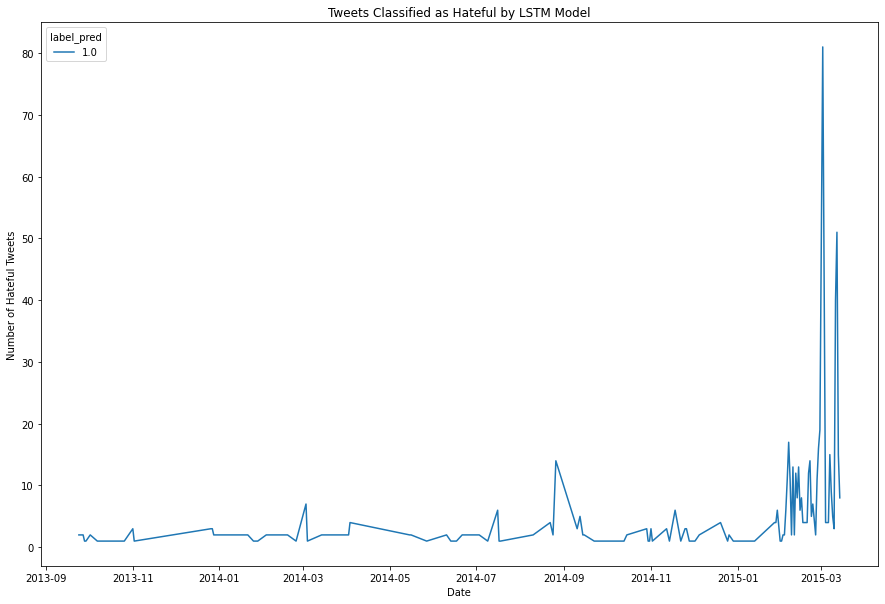

In [82]:
# View predicted hate comments over time
f, ax = plt.subplots(1,1,figsize=(15,10))

sns.lineplot('date_day', 'num_tweets',hue='label_pred', \
    data=tweet_preds_day[tweet_preds_day['label_pred']>0])

ax.set_xlabel("Date")
ax.set_ylabel("Number of Hateful Tweets")
ax.set_title("Tweets Classified as Hateful by LSTM Model")

### Compare with Google Trends

In [83]:
import pytrends
import pandas as pd
from pytrends.request import TrendReq
import matplotlib
import csv
from datetime import date
import time 
import requests
import warnings
warnings.filterwarnings('ignore')

pytrends = TrendReq(hl='en-US', tz=360)

In [84]:
keyword = ["nigger", "niggers", "kike", "chink", "faggot"]

pytrends.build_payload(keyword, cat=0, timeframe='2013-09-01 2015-04-01', geo='US', gprop='')
interest_over_time_df = pytrends.interest_over_time()

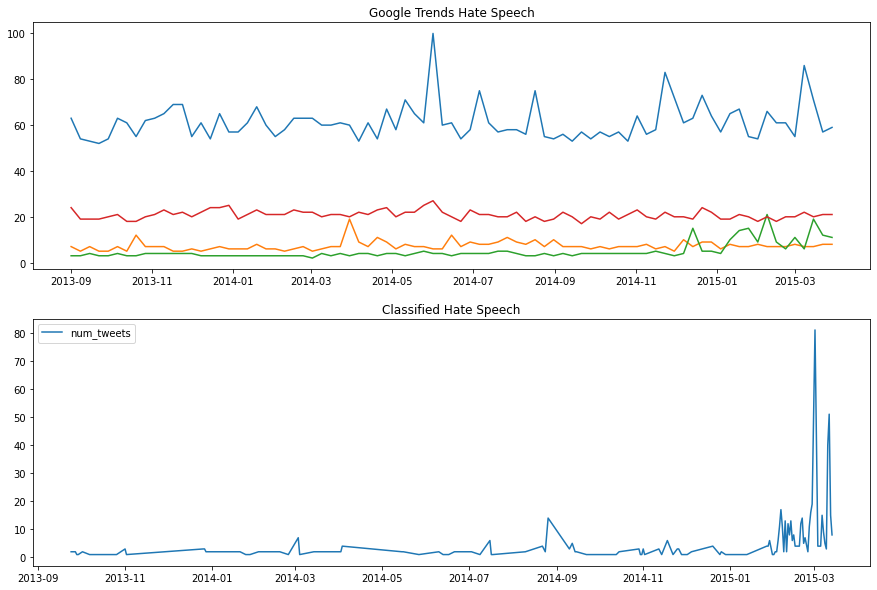

In [101]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))


ax1.plot(interest_over_time_df.index, interest_over_time_df["nigger"], label = "Anti-Black word")
ax1.plot(interest_over_time_df.index, interest_over_time_df["kike"], label = "Anti-Semitic word")
ax1.plot(interest_over_time_df.index, interest_over_time_df["chink"], label = "Anti-Asian word")
ax1.plot(interest_over_time_df.index, interest_over_time_df["faggot"], label = "Anti-LGBT word")
ax1.set_title("Google Trends Hate Speech")
ax2.plot('date_day', 'num_tweets', data=tweet_preds_day[tweet_preds_day['label_pred']>0])
ax2.set_title("Classified Hate Speech")
plt.plot()
plt.legend()
plt.show()
